# 一、 数据准备与预处理

In [123]:
import matplotlib.pyplot as plt

from functions import *

## 1. 加载文件内容

In [62]:
# 指定Enron数据集的路径
directory_path = 'Enron/EnronEmails'

# 处理目录并转换为DataFrame
# email_df = process_directory(directory_path)
# 耗时过长 实测3h+

# 读取提前处理的邮件表格
email_df = read_email_csv(directory_path)

# 显示部分数据
# print(email_df.head())

读取邮件csv文件:   0%|          | 0/150 [00:00<?, ?it/s]

In [63]:
# 读取POI邮箱地址
poi_emails = pd.read_csv('Enron/poi_email_addresses.csv', header=None, names=['email'])
poi_emails['email'] = poi_emails['email'].str.strip().str.lower()

# 读取POI姓名列表
with open('Enron/poi_names.txt', 'r') as f:
    poi_names = [line.strip().split(') ')[1] for line in f if line.startswith('(')]

## 2. 文件内容清洗

In [64]:
# 确保邮件数据有必要的列
required_columns = ['From', 'To', 'Cc', 'Bcc', 'Date', 'Subject', 'Body']
for col in required_columns:
    if col not in email_df.columns:
        email_df[col] = None

In [65]:
email_df['From_clean'] = email_df['From'].apply(clean_email)
email_df['To_clean'] = email_df['To'].apply(clean_email)
email_df['Cc_clean'] = email_df['Cc'].apply(clean_email)
email_df['Bcc_clean'] = email_df['Bcc'].apply(clean_email)

# 二、通信网络分析

## 1. POI识别与标记

In [66]:
# 使用 set 提高查找效率
poi_set = set(poi_emails['email'])

# 判断一封邮件的发送方、接收方、抄送方、密送方有无POI
email_df['from_poi'] = email_df['From_clean'].apply(lambda x: is_poi_involved(x, poi_set))
email_df['to_poi'] = email_df['To_clean'].apply(lambda x: is_poi_involved(x, poi_set))
email_df['cc_poi'] = email_df['Cc_clean'].apply(lambda x: is_poi_involved(x, poi_set))
email_df['bcc_poi'] = email_df['Bcc_clean'].apply(lambda x: is_poi_involved(x, poi_set))

# 标记是否为POI相关邮件
email_df['poi_related'] = email_df['from_poi'] | email_df['to_poi'] | email_df['cc_poi'] | email_df['bcc_poi']

In [67]:
# 提取POI之间的通信关系
# ：提取那些“发件人是 POI 且收件人中至少有一位也是 POI”的邮件记录，即只保留 POI 与 POI 之间的通信记录。
poi_communications = email_df[
    (email_df['from_poi']) & # 发件人是POI
    (email_df['to_poi'] | email_df['cc_poi'] | email_df['bcc_poi']) # 收件人是POI
].copy()

# 可以进一步分析POI之间的通信频率、时间模式等

## 2. 将POI通信信息转化为图

In [68]:
# 创建图对象（可换成 nx.DiGraph() 构建有向图）
G_poi = nx.Graph()

# 添加节点和边
for _, row in poi_communications.iterrows():
    sender = row['From_clean'][0] if row['From_clean'] else None
    recipients = row['To_clean'] + row['Cc_clean'] + row['Bcc_clean']
    
    for recipient in recipients:
        if sender and recipient and sender != recipient:
            G_poi.add_edge(sender, recipient)


## 3. 计算各个POI的中心性

In [115]:
# 度中心性（联系数量）
degree_centrality = nx.degree_centrality(G_poi)

# 介数中心性（信息中转重要性）
betweenness_centrality = nx.betweenness_centrality(G_poi)

# 特征向量中心性（影响力衡量）
eigenvector_centrality = nx.eigenvector_centrality(G_poi)

# 构建 DataFrame 查看排名
centrality_df = pd.DataFrame({
    'email': list(degree_centrality.keys()),
    'degree': list(degree_centrality.values()),
    'betweenness': list(betweenness_centrality.values()),
    'eigenvector': list(eigenvector_centrality.values())
}).sort_values(by='degree', ascending=False)

centrality_df = centrality_df.set_index('email')


## 4. 输出POI中心性排序

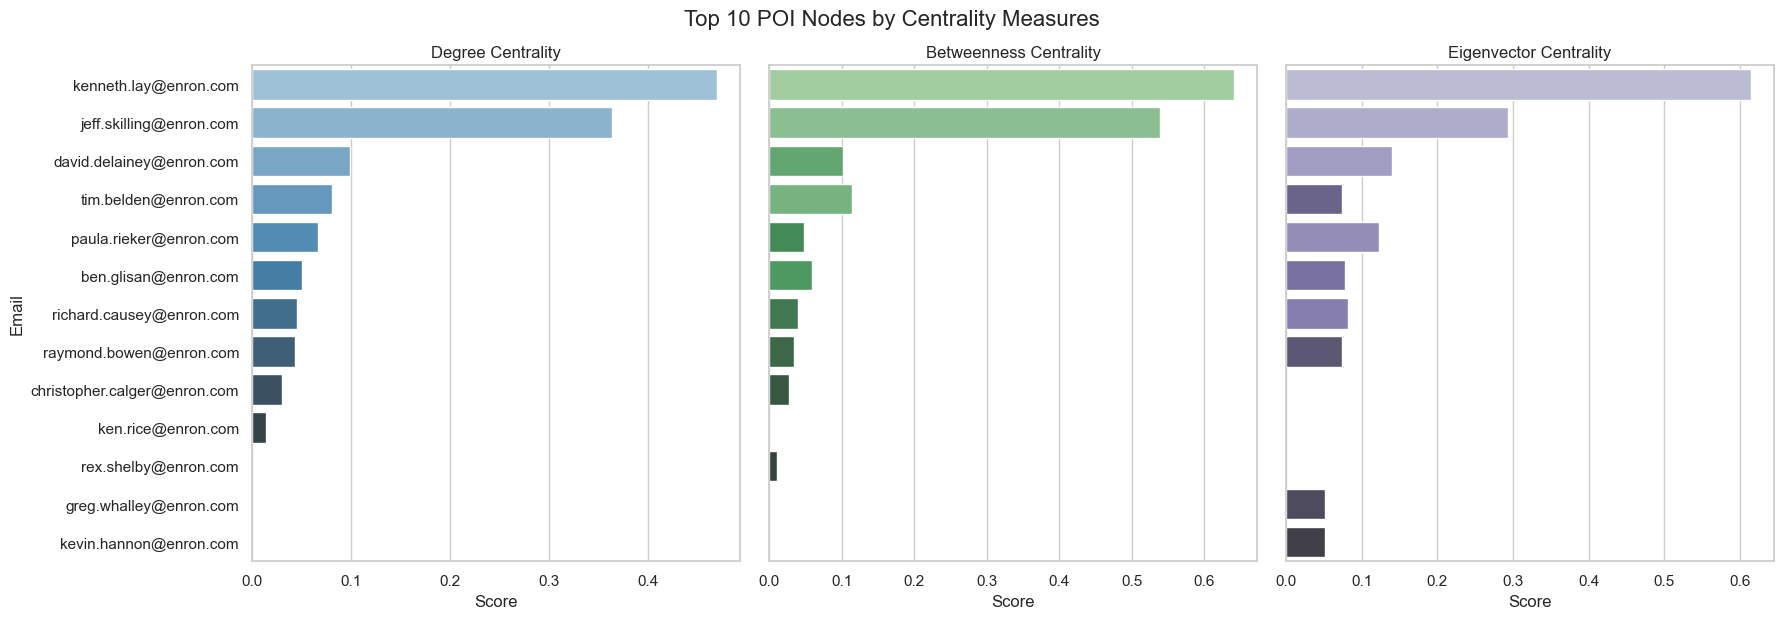

In [149]:
# 设置绘图风格
sns.set_theme(style="whitegrid")

# 创建子图布局
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# 度中心性
top_degree = centrality_df.sort_values('degree', ascending=False).head(10)
sns.barplot(data=top_degree, y='email', x='degree', palette='Blues_d', ax=axes[0],hue='email')
axes[0].set_title('Degree Centrality')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Email')

# 介数中心性
top_betweenness = centrality_df.sort_values('betweenness', ascending=False).head(10)
sns.barplot(data=top_betweenness, y='email', x='betweenness', palette='Greens_d', ax=axes[1],hue='email')
axes[1].set_title('Betweenness Centrality')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('')  # 避免重复

# 特征向量中心性
top_eigenvector = centrality_df.sort_values('eigenvector', ascending=False).head(10)
sns.barplot(data=top_eigenvector, y='email', x='eigenvector', palette='Purples_d', ax=axes[2],hue='email')
axes[2].set_title('Eigenvector Centrality')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('')

# 自动调整布局防止重叠
plt.tight_layout()
plt.suptitle("Top 10 POI Nodes by Centrality Measures", fontsize=16, y=1.03)

plt.savefig('results/Top 10 POI Nodes by Centrality Measures.pdf', dpi=300, bbox_inches='tight')
plt.show()

# 三、邮件内容分析

## 1. 提取邮件特征

In [117]:
# 邮件基本特征
email_df['body_length'] = email_df['Body'].str.len()
email_df['subject_length'] = email_df['Subject'].str.len()
email_df['num_recipients'] = email_df['To_clean'].apply(len) + email_df['Cc_clean'].apply(len) + email_df['Bcc_clean'].apply(len)
email_df['has_attachment'] = email_df['Attachments'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)

In [118]:
# 时间特征
email_df['Date'] = pd.to_datetime(email_df['Date'],utc=True)

email_df['hour'] = email_df['Date'].dt.hour
email_df['day_of_week'] = email_df['Date'].dt.dayofweek
email_df['is_weekend'] = email_df['day_of_week'].isin([5, 6])

## 2. 提取邮件正文TF-IDF特征

In [119]:
# TF-IDF特征提取时间较长，运行时保存方便下次运行节省时间
# 检查是否已有保存文件
tfidf_matrix_path = 'artifacts/tfidf_features.npz'
vectorizer_path = 'artifacts/tfidf_vectorizer.pkl'
cleaned_df_path = 'artifacts/email_df_cleaned.pkl'

if os.path.exists(tfidf_matrix_path) and os.path.exists(vectorizer_path) and os.path.exists(cleaned_df_path):
    print("加载已保存的 TF-IDF 特征...")
    tfidf_features = sparse.load_npz(tfidf_matrix_path)
    tfidf = joblib.load(vectorizer_path)
    email_df = pd.read_pickle(cleaned_df_path)
else:
    print("开始清洗正文并提取 TF-IDF 特征...")

    email_df['clean_body'] = email_df['Body'].apply(clean_text)
    
    # 提取 TF-IDF 特征
    
    # TF-IDF 特征提取器，用于将文本转换为数值特征
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    # 把上面的模型应用到数据上，生成了稀疏的特征矩阵
    tfidf_features = tfidf.fit_transform(email_df['clean_body'])

    # 保存结果
    sparse.save_npz(tfidf_matrix_path, tfidf_features)
    joblib.dump(tfidf, vectorizer_path)
    email_df.to_pickle(cleaned_df_path)
    print("已保存 TF-IDF 特征和清洗后的数据")

加载已保存的 TF-IDF 特征...


## 3. 提取可疑特征

In [120]:
# 可疑关键词检测
fraud_keywords = ['confidential', 'urgent', 'secret', 'destroy', 'shred', 'cover up',
                 'mislead', 'misrepresent', 'fraud', 'illegal', 'off the record']

for keyword in fraud_keywords:
    email_df[f'contains_{keyword}'] = email_df['clean_body'].str.contains(keyword)

# 非工作时间发送的邮件
email_df['after_hours'] = (email_df['hour'] < 8) | (email_df['hour'] > 18)

# 大量密送的邮件
email_df['high_bcc'] = email_df['Bcc_clean'].apply(len) > 5

## 4.提取POI中心性特征

In [125]:
def get_centrality(sender_list, centrality_df):
    sender = sender_list[0] if sender_list else None
    if sender in centrality_df.index:
        return centrality_df.loc[sender].values  # 返回 degree, betweenness, eigenvector
    else:
        return np.zeros(3)

In [126]:
# 构建中心性特征矩阵
centrality_features = np.array([
    get_centrality(sender,centrality_df) for sender in email_df['From_clean']
])

In [127]:
centrality_sparse = csr_matrix(centrality_features)

## 5. 欺诈检测模型构建

### (1) 训练数据准备

In [128]:
email_df['poi_related'].value_counts(normalize=True)

poi_related
False    0.941875
True     0.058125
Name: proportion, dtype: float64

In [129]:
# 确保数值特征为float类型
numerical_features = email_df[['body_length', 'subject_length', 'num_recipients', 
                             'hour', 'day_of_week']].astype(float).values

# 确保布尔特征为float类型
bool_features = email_df[[f'contains_{k}' for k in fraud_keywords]].astype(float).values

# 合并所有特征
X = hstack([
    tfidf_features,
    numerical_features,
    email_df[['has_attachment', 'is_weekend', 'after_hours', 'high_bcc']].astype(float).values,
    bool_features,
    centrality_sparse
])

y = email_df['poi_related'].values

In [130]:
# 平衡样本
X = X.toarray()
X.data = np.nan_to_num(X.data, nan=0)

print(f"原始样本分布: {Counter(y)}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"平衡后样本分布: {Counter(y_resampled)}")

C:\Users\79387\AppData\Local\Temp\ipykernel_5224\2438980280.py:6: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  X.data = np.nan_to_num(X.data, nan=0)


原始样本分布: Counter({False: 487316, True: 30073})
平衡后样本分布: Counter({False: 487316, True: 487316})


### (2) 模型训练与评估

In [131]:
model_path = 'artifacts/rf_model.pkl'

# 1. 数据预处理
X.data = np.nan_to_num(X.data, nan=0)

# 2. 训练或加载模型
print('正在分割数据')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

if os.path.exists(model_path):
    print('加载已有模型')
    model = joblib.load(model_path)
    
else:
    print('正在训练模型')
    model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1,class_weight='balanced')
    model.fit(X_train, y_train)

    print('正在保存模型')
    joblib.dump(model, model_path)

print('正在评估模型')
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\79387\AppData\Local\Temp\ipykernel_5224\1643088647.py:10: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  X.data = np.nan_to_num(X.data, nan=0)


正在分割数据
正在训练模型


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


正在保存模型
正在评估模型


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished


              precision    recall  f1-score   support

       False       0.99      1.00      1.00     97511
        True       0.99      0.87      0.93      5967

    accuracy                           0.99    103478
   macro avg       0.99      0.93      0.96    103478
weighted avg       0.99      0.99      0.99    103478



### (3) 输出最重要的特征

In [133]:
# 获取TF-IDF特征名
tfidf_feature_names = tfidf.get_feature_names_out()

# 其他特征名
other_feature_names = np.array([
    'body_length', 'subject_length', 'num_recipients', 'has_attachment',
    'hour', 'day_of_week', 'is_weekend', 'after_hours', 'high_bcc'
] + [f'contains_{k}' for k in fraud_keywords]+ \
    ['degree', 'betweenness', 'eigenvector'])

# 正确合并特征名
feature_names = np.concatenate([tfidf_feature_names, other_feature_names])

# 创建DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

print(feature_importance_df['feature'])

1002    num_recipients
1020            degree
1022       eigenvector
1021       betweenness
1000       body_length
1001    subject_length
879            subject
519                lay
1008          high_bcc
506                ken
488               jeff
176                 cc
1003    has_attachment
758            regards
710              power
914                tim
129           attached
203                com
264              david
312                ect
Name: feature, dtype: object


## 6. 输出特征重要性

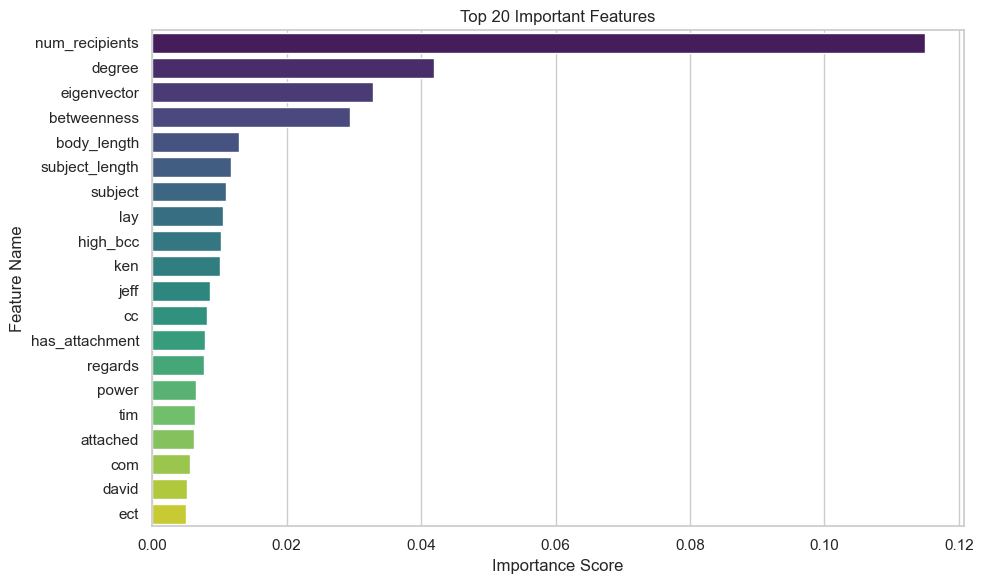

In [150]:
# 设置画图风格
sns.set_theme(style="whitegrid")

# 提取前20个重要特征
top_features = feature_importance_df.head(20)

# 创建柱状图
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x='importance',
    y='feature',
    hue='feature',      
    palette='viridis',
    dodge=False         
)

# 设置标题和标签
plt.title('Top 20 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# 展示图表
plt.tight_layout()
plt.savefig('results/Top 20 Important Features.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 7. 欺诈模型应用

### (1) 识别邮件风险分数

In [143]:
# 预测所有邮件的风险分数
email_df['fraud_score'] = model.predict_proba(X)[:, 1]

# 将 fraud_score 转换为百分比格式，保留两位小数
email_df['fraud_score_percent'] = (email_df['fraud_score'] * 100).round(2)

# 只保留相关字段
email_score_df = email_df[[
    'From', 'To', 'Cc', 'Bcc',
    'fraud_score'
]]

# 保存为 CSV 文件
email_score_df.to_csv('results/email_risk_scores.csv', index=False, encoding='utf-8')

# 获取随机50封邮件并显示百分比形式的风险分数
random_50_emails = email_df.sample(n=50)
random_50_emails[['From', 'To', 'Subject', 'Date', 'fraud_score_percent']]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


,From,To,Subject,Date,fraud_score_percent
87679,pete.davis@enron.com,pete.davis@enron.com,Start Date: 10/9/01; HourAhead hour: 20; <COD...,2001-10-10 00:38:23+00:00,0.0
155335,paul.devries@enron.com,stephen.douglas@enron.com,Re: Tax Planning - Privileged Solicitor/Client...,2000-11-16 14:08:00+00:00,2.0
314985,kay.mann@enron.com,matthew.gockerman@enron.com,CA I and II Bills of Sale,2001-01-10 11:13:00+00:00,0.0
398390,richard.sanders@enron.com,ctetrault@velaw.com,Re: DOJ,2000-03-07 20:18:00+00:00,0.0
301575,kay.mann@enron.com,suzanne.adams@enron.com,Coop City,2001-01-04 18:00:00+00:00,1.0
102647,megan.parker@enron.com,daren.farmer@enron.com,Re: Duke Cashout Entries 5/00 and 6/00,2000-10-05 17:08:00+00:00,0.0
50899,e..carter@enron.com,monika.causholli@enron.com,RE: Chilean pulp capacity,2001-10-17 16:02:05+00:00,0.0
402169,tk.lohman@enron.com,"vincent.strohmeyer@enron.com, debbie.moseley@e...",Confirmations,2002-02-08 14:52:12+00:00,0.0
510881,pete.davis@enron.com,pete.davis@enron.com,Start Date: 1/31/02; HourAhead hour: 3;,2002-01-31 12:37:04+00:00,0.0
38990,shirley.cox@enron.com,"clement.abrams@enron.com, naveen.andrews@enron...",Mid-Year Purge - PEP System,2001-08-29 20:01:13+00:00,8.0


### (2) 生成POI活动摘要

In [136]:
# 生成POI活动摘要
poi_activity = email_df[email_df['poi_related']].groupby(
    email_df['From_clean'].apply(lambda x: x[0] if x else 'unknown')
).agg({
    'fraud_score': 'mean',
    'From': 'count',
    'has_attachment': 'sum',
    'after_hours': 'sum'
}).rename(columns={'From': 'email_count', 'has_attachment': 'attachments', 'after_hours': 'after_hours_emails'})

poi_activity.sort_values('fraud_score', ascending=False)

,fraud_score,email_count,attachments,after_hours_emails
From_clean,,,,
110165.74@compuserve.com,1.00,1,0,0
marlya0264@aol.com,1.00,1,0,0
duchess6206@yahoo.com,1.00,1,0,1
dtharpe@mac1988.com,1.00,1,0,0
dsjames@tribune.com,1.00,1,0,0
...,...,...,...,...
susan.gardenfeld@weil.com,0.01,1,0,0
wired@condenast.flonetwork.com,0.01,1,0,1
dalak@hotmail.com,0.00,1,0,1
